<a href="https://colab.research.google.com/github/amd257/COVID-detection-using-CNNs/blob/main/Parallel_Sequential_ThreeLabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Compressed Three Label Dataset file is stored at: https://www.dropbox.com/s/7avu1oypedrerxl/Dataset.zip?dl=0

!wget https://www.dropbox.com/s/7avu1oypedrerxl/Dataset.zip?dl=0

--2021-02-25 10:43:39--  https://www.dropbox.com/s/7avu1oypedrerxl/Dataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7avu1oypedrerxl/Dataset.zip [following]
--2021-02-25 10:43:39--  https://www.dropbox.com/s/raw/7avu1oypedrerxl/Dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca89c0cf90945422cf70192d6a7.dl.dropboxusercontent.com/cd/0/inline/BJk7EsSogbXsxtbz7pSGLv5kCMC32YQRjv8ev2lFjmQ9SNtueVVwcw9Kd3Z8YqzNpkeb0VSYqpF1ezuB6aEYnRLIyMlieOQkYWjrcp9KD9uQPde9-ah__dFaW_vz6YdtbYo/file# [following]
--2021-02-25 10:43:39--  https://uca89c0cf90945422cf70192d6a7.dl.dropboxusercontent.com/cd/0/inline/BJk7EsSogbXsxtbz7pSGLv5kCMC32YQRjv8ev2lFjmQ9SNtueVVwcw9Kd3Z8YqzNpkeb0VSYqpF1ezuB6aEYnRLIyMlieOQkYWjrcp9KD9uQP

In [ ]:
#Extracting the compressed dataset
!unzip /content/Dataset.zip?dl=0

Archive:  /content/Dataset.zip?dl=0
   creating: Dataset/
   creating: Dataset/Test/
   creating: Dataset/Test/COVID/
  inflating: Dataset/Test/COVID/COVID (1001).png  
  inflating: Dataset/Test/COVID/COVID (1005).png  
  inflating: Dataset/Test/COVID/COVID (1012).png  
  inflating: Dataset/Test/COVID/COVID (1015).png  
  inflating: Dataset/Test/COVID/COVID (1019).png  
  inflating: Dataset/Test/COVID/COVID (1025).png  
  inflating: Dataset/Test/COVID/COVID (1027).png  
  inflating: Dataset/Test/COVID/COVID (1042).png  
  inflating: Dataset/Test/COVID/COVID (1043).png  
  inflating: Dataset/Test/COVID/COVID (1044).png  
  inflating: Dataset/Test/COVID/COVID (107).png  
  inflating: Dataset/Test/COVID/COVID (1073).png  
  inflating: Dataset/Test/COVID/COVID (1095).png  
  inflating: Dataset/Test/COVID/COVID (1099).png  
  inflating: Dataset/Test/COVID/COVID (113).png  
  inflating: Dataset/Test/COVID/COVID (1132).png  
  inflating: Dataset/Test/COVID/COVID (1143).png  
  inflating: Data

In [ ]:
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing import image
from keras.layers import *
from keras.models import *
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_images_path = "Dataset/Train"
validation_images_path = "Dataset/Validation"
test_images_path = "Dataset/Test"

In [ ]:
#Training data augmentation before feeding it to the CNN model
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,  #flipping will add more variations to the data and it will help fight overfitting as welll
    )

#Preprocessing the training data
train_generator= train_datagen.flow_from_directory(
    train_images_path,
    target_size = (100,100),
    batch_size = 32,
    color_mode="grayscale",
    class_mode = "categorical",
    shuffle = True,
    seed =40
    )

train_generator.class_indices
train_generator.image_shape

Found 3108 images belonging to 3 classes.


(100, 100, 1)

In [ ]:
validation_dataset = image.ImageDataGenerator(rescale = 1./255) #Rescaling the validation images 

#Preprocessing the validation dataset
validation_generator = validation_dataset.flow_from_directory(
    validation_images_path,
    target_size = (100,100),
    batch_size = 32,
    color_mode = "grayscale" ,
    class_mode = "categorical",
    shuffle = True,
    seed =40
    )

validation_generator.class_indices

Found 388 images belonging to 3 classes.


{'COVID': 0, 'Normal': 1, 'ViralPneumonia': 2}

In [ ]:
#Creating the parallel sequential model
input_shape = train_generator.image_shape
input=Input(shape = input_shape) 
# used to be (256,256,1) but that led to too many parameters, changed to (100,100,1) and model runs fine now
convs=[]
parrallel_kernels=[3,5,7]

for i in range(len(parrallel_kernels)):
  conv = Conv2D(128, parrallel_kernels[i],padding = 'same',activation='relu',input_shape=input_shape,strides=1)(input)
  convs.append(conv)

output = Concatenate()(convs)
conv_model = Model(input,output)

In [ ]:
model = Sequential()
model.add(conv_model) # Added the conv_model with the parallel kernels to the sequential model

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='sigmoid')) #sigmoid/softmax for this layer 
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 100, 100, 384)     11008     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 98, 98, 64)        221248    
_________________________________________________________________
activation (Activation)      (None, 98, 98, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 47, 32)        18464     
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0

(None, 100, 100, 1)


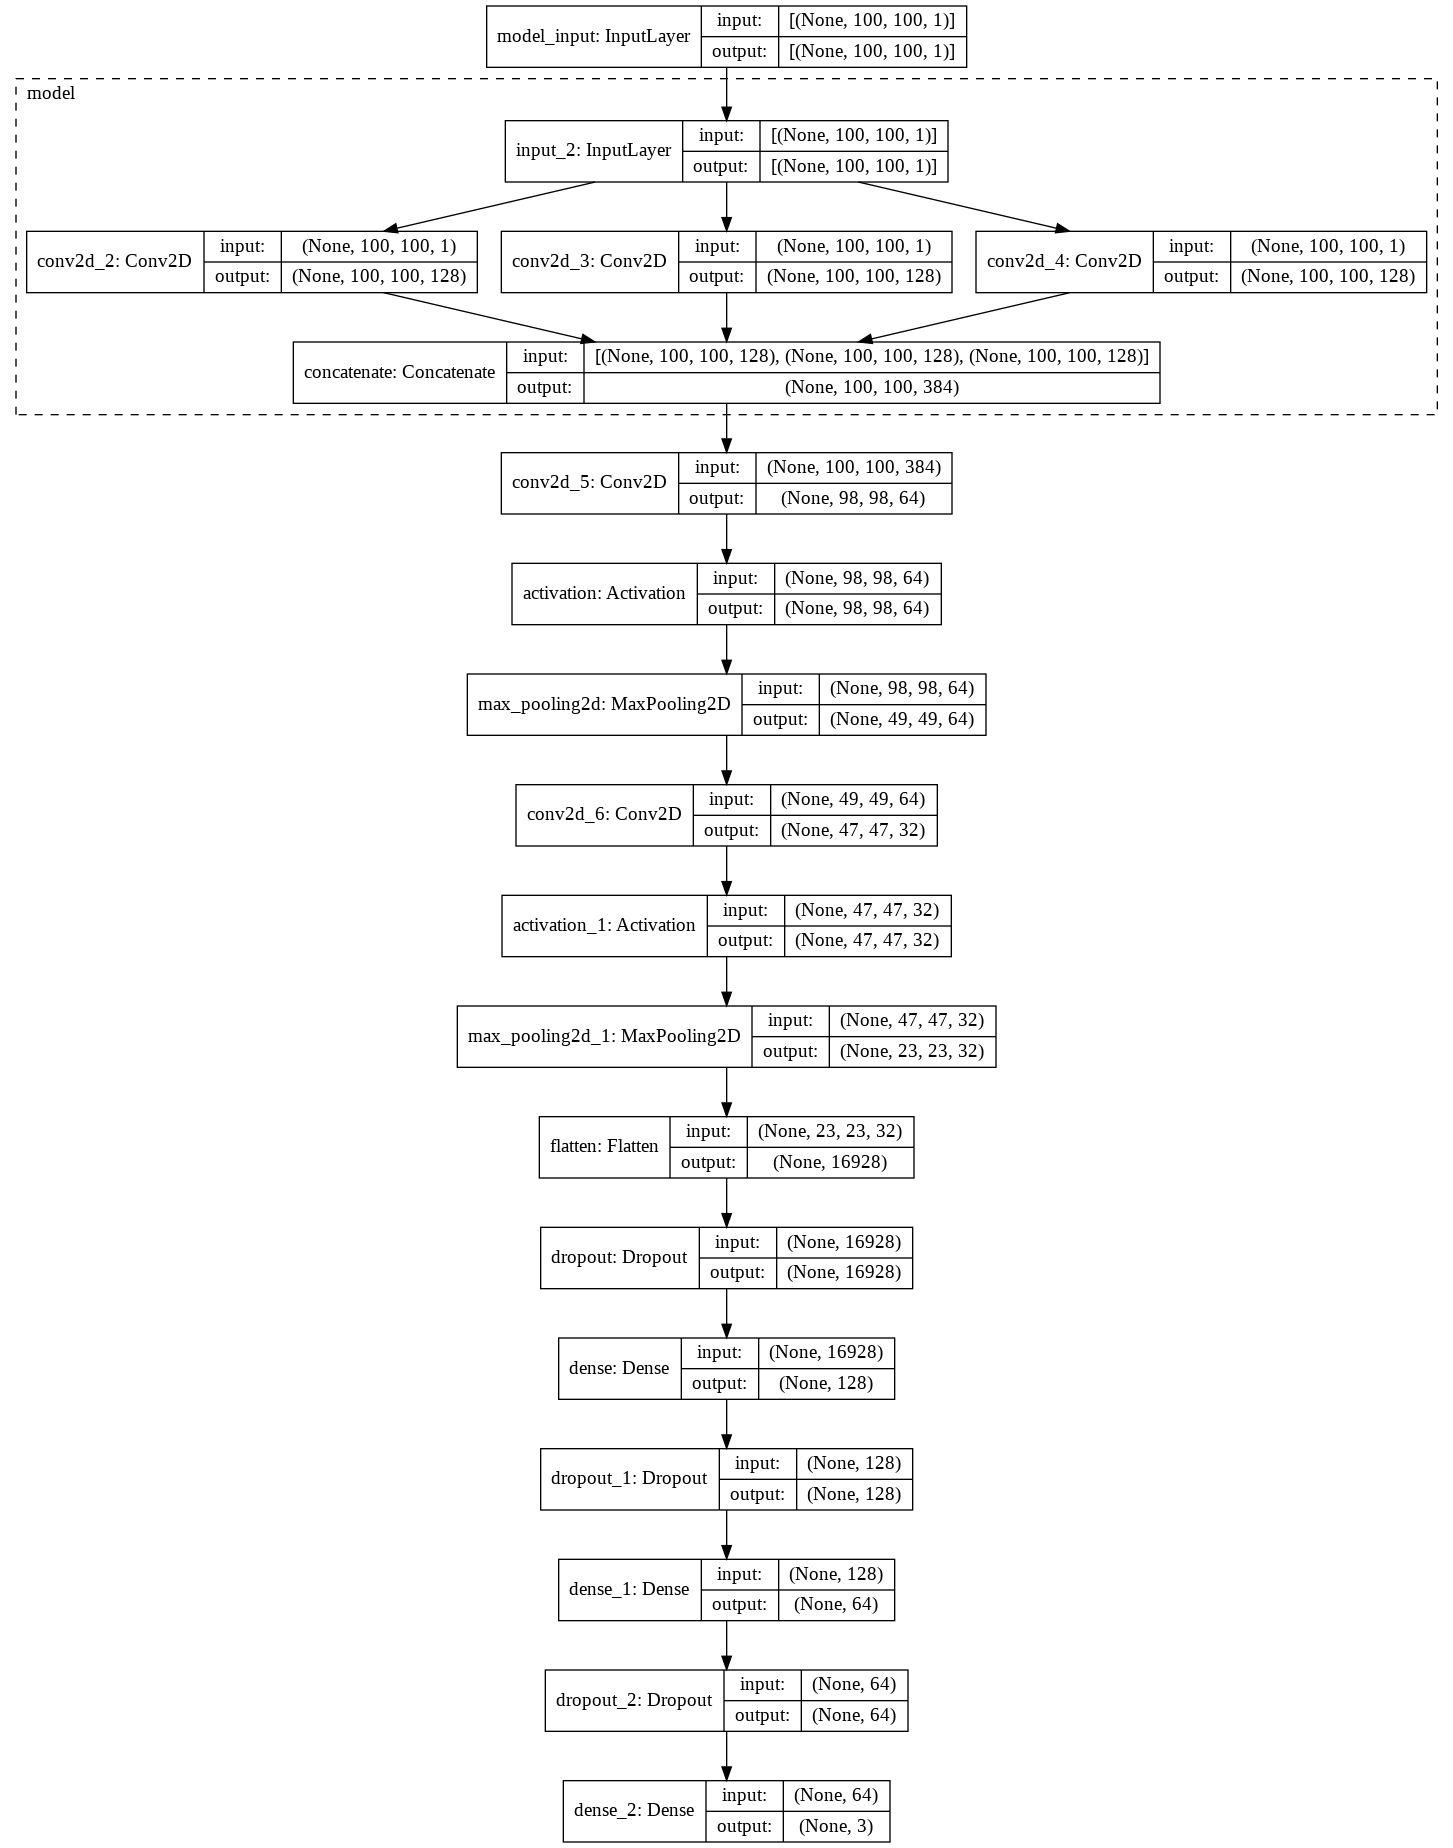

In [ ]:
print(model.input.shape)
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

97
12


In [ ]:
history = model.fit(
    train_generator, 
    steps_per_epoch = STEP_SIZE_TRAIN, 
    epochs=25,
    validation_data = validation_generator,
    validation_steps = STEP_SIZE_VALID
    )

Epoch 1/25
97/97 [==============================] - 54s 482ms/step - loss: 1.0133 - accuracy: 0.4428 - val_loss: 0.5902 - val_accuracy: 0.8021
Epoch 2/25
97/97 [==============================] - 47s 481ms/step - loss: 0.6417 - accuracy: 0.7038 - val_loss: 0.4414 - val_accuracy: 0.8958
Epoch 3/25
97/97 [==============================] - 47s 482ms/step - loss: 0.5279 - accuracy: 0.8092 - val_loss: 0.3307 - val_accuracy: 0.8516
Epoch 4/25
97/97 [==============================] - 47s 481ms/step - loss: 0.4909 - accuracy: 0.8079 - val_loss: 0.3174 - val_accuracy: 0.8854
Epoch 5/25
97/97 [==============================] - 47s 478ms/step - loss: 0.4367 - accuracy: 0.8264 - val_loss: 0.2685 - val_accuracy: 0.9010
Epoch 6/25
97/97 [==============================] - 46s 476ms/step - loss: 0.4259 - accuracy: 0.8376 - val_loss: 0.2426 - val_accuracy: 0.9193
Epoch 7/25
97/97 [==============================] - 46s 473ms/step - loss: 0.4006 - accuracy: 0.8548 - val_loss: 0.2278 - val_accuracy: 0.9167

In [ ]:
model.save('ParallelSeq_ThreeLabel.h5')

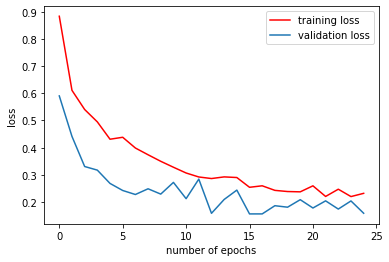

In [ ]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

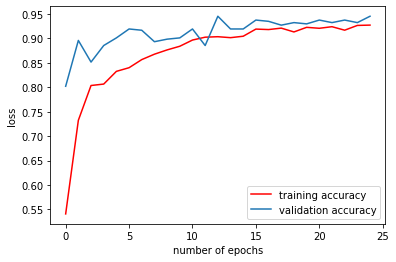

In [ ]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()